In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import mysql.connector


db=mysql.connector.connect(host="localhost",
                           username="root",
                           password="Bakhshial",
                           database="e_commers"
                          )
cursor=db.cursor()

# Basic Queries

### 1. List all unique cities where customers are located.

In [2]:
query=""" select distinct customer_city from customers limit 10"""
cursor.execute(query)
data=cursor.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',)]

### 2. Count the number of orders placed in 2017.

In [3]:
query=""" select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cursor.execute(query)

data=cursor.fetchall()
print("Total orders placed in 2017 are: ",data[0][0])

Total orders placed in 2017 are:  45101


### 3. Find the total sales per category.

In [4]:
query=""" select p.product_category, round(sum(pm.payment_value),2) 
from products p
inner join
order_items o on p.product_id=o.product_id
inner join payments pm on pm.order_id=o.order_id
group by p.product_category order by 2 desc limit 5"""

cursor.execute(query)

data=cursor.fetchall()
data

[('bed table bath', 1712553.67),
 ('HEALTH BEAUTY', 1657373.12),
 ('computer accessories', 1585330.45),
 ('Furniture Decoration', 1430176.39),
 ('Watches present', 1429216.68)]

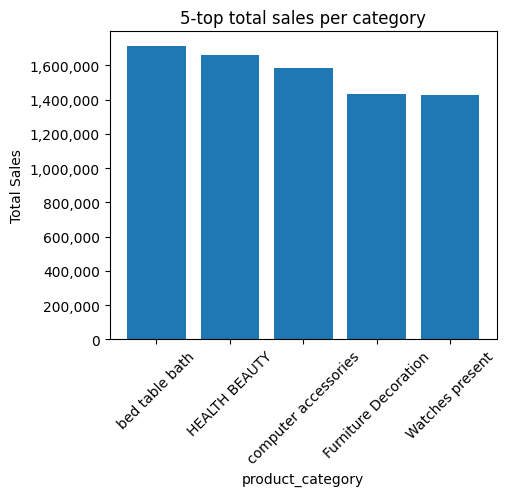

In [5]:
df=pd.DataFrame(data, columns=("product_category","Sales"))

fig, ax = plt.subplots(figsize=(5, 4))
plt.bar(df["product_category"],df["Sales"])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.title("5-top total sales per category")
plt.xlabel("product_category")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.show()

### 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query=""" select 
(sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 
from payments 
"""

cursor.execute(query)

data=cursor.fetchall()
print("Calculate the percentage of orders that were paid in installments: ",data[0][0])

Calculate the percentage of orders that were paid in installments:  99.9981


### 5. Count the number of customers from each state.

In [7]:
query=""" select customer_state, count(customer_id) from customers
group by customer_state order by 2 desc;
"""

cursor.execute(query)

data=cursor.fetchall()
print("Count the number of customers from each state: ",data)

Count the number of customers from each state:  [('SP', 41746), ('RJ', 12852), ('MG', 11635), ('RS', 5466), ('PR', 5045), ('SC', 3637), ('BA', 3380), ('DF', 2140), ('ES', 2033), ('GO', 2020), ('PE', 1652), ('CE', 1336), ('PA', 975), ('MT', 907), ('MA', 747), ('MS', 715), ('PB', 536), ('PI', 495), ('RN', 485), ('AL', 413), ('SE', 350), ('TO', 280), ('RO', 253), ('AM', 148), ('AC', 81), ('AP', 68), ('RR', 46)]


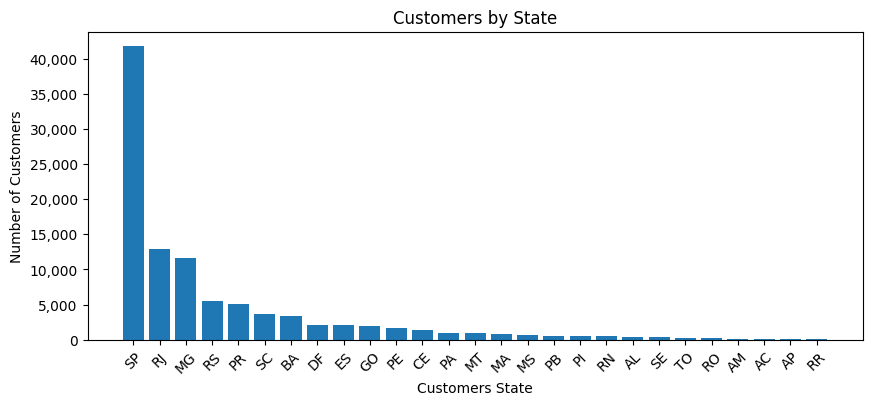

In [8]:
df=pd.DataFrame(data, columns=("Customers State","Number of Customers"))

fig, ax = plt.subplots(figsize=(10, 4))
plt.bar(df["Customers State"],df["Number of Customers"])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.title("Customers by State")
plt.xlabel("Customers State")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()

# Intermediate Queries

### 1. Calculate the number of orders per month in 2018.

In [9]:
query=""" select monthName(order_purchase_timestamp) month, count(order_id) order_count from orders
where year(order_purchase_timestamp) =2018
group by month order by 2 desc;
"""

cursor.execute(query)

data=cursor.fetchall()
print("Calculate the number of orders per month in 2018:\n ",data)

Calculate the number of orders per month in 2018:
  [('January', 7269), ('March', 7211), ('April', 6939), ('May', 6873), ('February', 6728), ('August', 6512), ('July', 6292), ('June', 6167), ('September', 16), ('October', 4)]


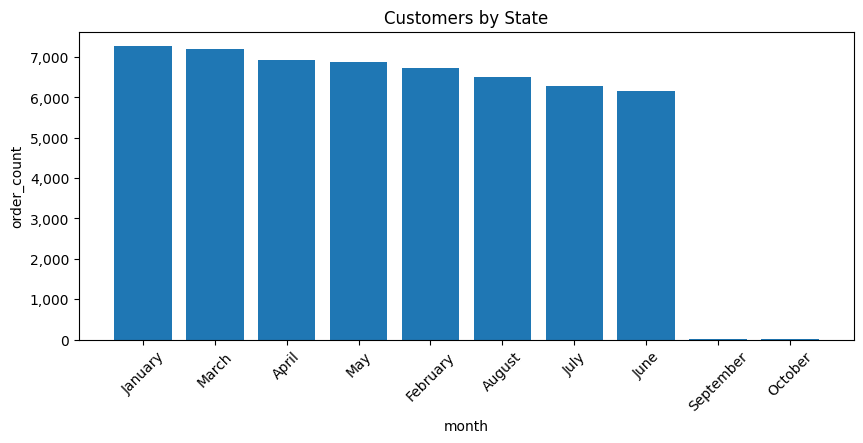

In [10]:
df=pd.DataFrame(data, columns=("month","order_count"))

fig, ax = plt.subplots(figsize=(10, 4))
plt.bar(df["month"],df["order_count"])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.title("Customers by State")
plt.xlabel("month")
plt.ylabel("order_count")
plt.xticks(rotation=45)
plt.show()

### 2. Find the average number of products per order, grouped by customer city.

In [11]:
query=""" with count_per_order as
(select o.order_id,o.customer_id,count(oi.order_id) order_count
from orders o
join
order_items oi on o.order_id=oi.order_id
group by o.order_id,o.customer_id)
select c.customer_city, round(avg(count_per_order.order_count),2) avg_order
from customers c
join
count_per_order on c.customer_id=count_per_order.customer_id
group by c.customer_city order by 2 desc;
"""

cursor.execute(query)

data=cursor.fetchall()
df=pd.DataFrame(data, columns=("customer_city","avg_order"))
df.head()

,customer_city,avg_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


### 3. Calculate the percentage of total revenue contributed by each product category.

In [12]:
query=""" select p.product_category,
round(sum(pm.payment_value)/(select sum(payments.payment_value) from payments)*100,2) sales_percentage
from products p
inner join
order_items o on p.product_id=o.product_id
inner join payments pm on pm.order_id=o.order_id
group by p.product_category order by 2 desc;"""

cursor.execute(query)

data=cursor.fetchall()
df=pd.DataFrame(data, columns=("product_category","percentage_of_total_revenue"))
df.head(10)

,product_category,percentage_of_total_revenue
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


### 4. Identify the correlation between product price and the number of times a product has been purchased.

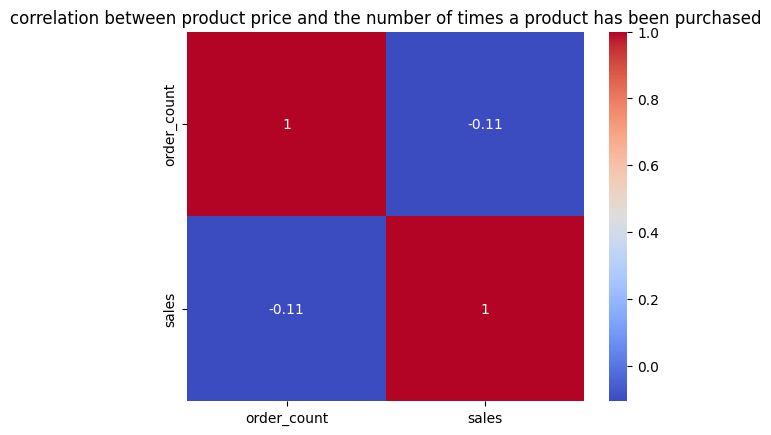

In [24]:
query=""" select products.product_category,
count(order_items.product_id) order_count,
round(avg(order_items.price),2) sale
from products
join
order_items on products.product_id=order_items.product_id
group by products.product_category;
"""

cursor.execute(query)

data=cursor.fetchall()
df=pd.DataFrame(data, columns=("product_category","order_count","sales"))
# Check if columns exist (optional)
if all(col in df.columns for col in ['order_count', 'sales']):
  # Calculate correlation matrix
  corr_matrix = df[['order_count', 'sales']].corr()

  # Create heatmap
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
  plt.title('correlation between product price and the number of times a product has been purchased')
  plt.show()
else:
  print("Columns 'order_count' or 'sales' not found in DataFrame")

### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [26]:
query=""" select *, dense_rank() over(order by revenue desc) as revenue from
(select oi.seller_id as seller, round(sum(p.payment_value),2) revenue
from order_items oi join payments p
on oi.order_id=p.order_id
group by seller) as a
"""

cursor.execute(query)

data=cursor.fetchall()
df=pd.DataFrame(data, columns=("Seller","Revenue","Rank"))
df.head(10)

,Seller,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


#### Top five seller that generate more revenue

In [17]:
query=""" select *, dense_rank() over(order by revenue desc) as revenue from
(select oi.seller_id as seller, round(sum(p.payment_value),2) revenue
from order_items oi join payments p
on oi.order_id=p.order_id
group by seller) as a
limit 5
"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=("Seller","Revenue","Rank"))
df=df.head()
df

,Seller,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


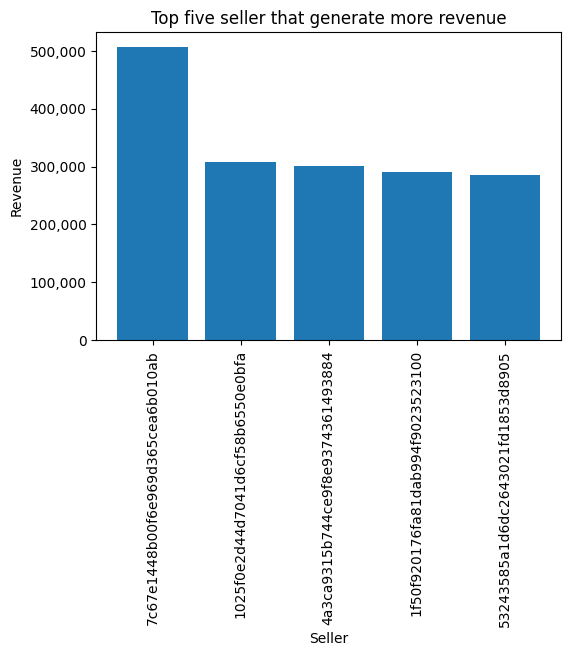

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(df["Seller"],df["Revenue"])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.title("Top five seller that generate more revenue")
plt.xlabel("Seller")
plt.ylabel("Revenue")
plt.xticks(rotation=90)
plt.show()

# Advanced Queries

### 1. Calculate the moving average of order values for each customer over their order history.

In [29]:
query=""" select customer_id,order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as moving_avg
from
(select o.customer_id, o.order_purchase_timestamp, p.payment_value as payment
from orders o join payments p
on o.order_id=p.order_id)  as a;
"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=("customer_id","order_purchase_timestamp","payment"," moving_avg"))
df.head(10)

,customer_id,order_purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


### 2. Calculate the cumulative sales per month for each year.

In [37]:
query=""" select years,months,payment, sum(payment)
over(order by years,months) cumulativ_sale from 
(select year(o.order_purchase_timestamp) years,
monthname(o.order_purchase_timestamp) months,
round(sum(p.payment_value),2) as payment
from orders o join payments p
on o.order_id=p.order_id
group by years,months order by payment desc) as a; 
"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=("years","months","payment","cumulativ_sale"))
df.head(10)

,years,months,payment,cumulativ_sale
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69
5,2017,December,878401.48,2029948.17
6,2017,February,291908.01,2321856.18
7,2017,January,138488.04,2460344.22
8,2017,July,592382.92,3052727.14
9,2017,June,511276.38,3564003.52


### 3. Calculate the year-over-year growth rate of total sales.

In [39]:
query=""" with a as
(select year(o.order_purchase_timestamp) years,
round(sum(p.payment_value),2) as payment
from orders o join payments p
on o.order_id=p.order_id
group by years)

select years,payment, ((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 YOY_Percentage from a
; 
"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=("years","payment","YOY_Percentage"))
df.head()

,years,payment,YOY_Percentage
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


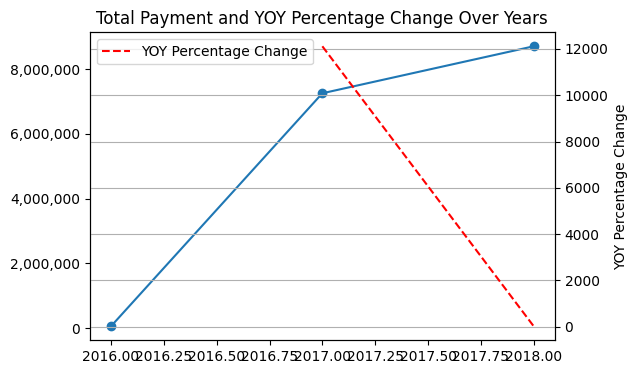

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

# Plot total payment
plt.plot(df['years'], df['payment'], label='Total Payment', marker='o')

# Plot YOY percentage change as a secondary y-axis
ax2 = plt.twinx()
ax2.plot(df['years'], df['YOY_Percentage'], color='red', linestyle='--', label='YOY Percentage Change')

plt.title('Total Payment and YOY Percentage Change Over Years')
plt.xlabel('Year')
plt.ylabel('Total Payment')
ax2.set_ylabel('YOY Percentage Change')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.legend()
plt.grid(True)
plt.show()

### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [54]:
query=""" WITH a AS (
  SELECT c.customer_id, MIN(o.order_purchase_timestamp) AS first_order
  FROM customers c
  JOIN orders o ON c.customer_id = o.customer_id
  GROUP BY c.customer_id
),
b AS (
  SELECT a.customer_id, COUNT(o.order_purchase_timestamp) AS repeat_customers
  FROM a
  JOIN orders o ON a.customer_id = o.customer_id
  AND o.order_purchase_timestamp > first_order
  AND o.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
  GROUP BY a.customer_id
)
SELECT 
  100 * COUNT(b.customer_id) / COUNT(a.customer_id) AS retention_rate
FROM a
LEFT JOIN b ON a.customer_id = b.customer_id;
"""

cursor.execute(query)
data=cursor.fetchall()

retention_rate = data[0][0]  # Extract the retention rate
if retention_rate>0:
    print("Percentage of retention rate of customers who make another purchase within 6 months of their first purchase:", retention_rate)
else:
    print("No another purchase within 6 months of their first purchase",retention_rate)



No another purchase within 6 months of their first purchase 0.0000


### 5. Identify the top 3 customers who spent the most money in each year.

In [55]:
query=""" select years, customer_id, payment, d_rank
from
(select o.customer_id, year(o.order_purchase_timestamp) as years, sum(p.payment_value) as payment,
dense_rank() over(partition by year(o.order_purchase_timestamp) order by  sum(p.payment_value) desc) d_rank
from orders o join payments p
on o.order_id=p.order_id
group by years,o.customer_id) as a
where d_rank<=3;
"""

cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=("customer_id","years","payment","d_rank"))
df

,customer_id,years,payment,d_rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


C:\Users\Invisible Boy\AppData\Local\Temp\ipykernel_7396\105866035.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="years", y="payment", hue="customer_id", data=df, ci=None)


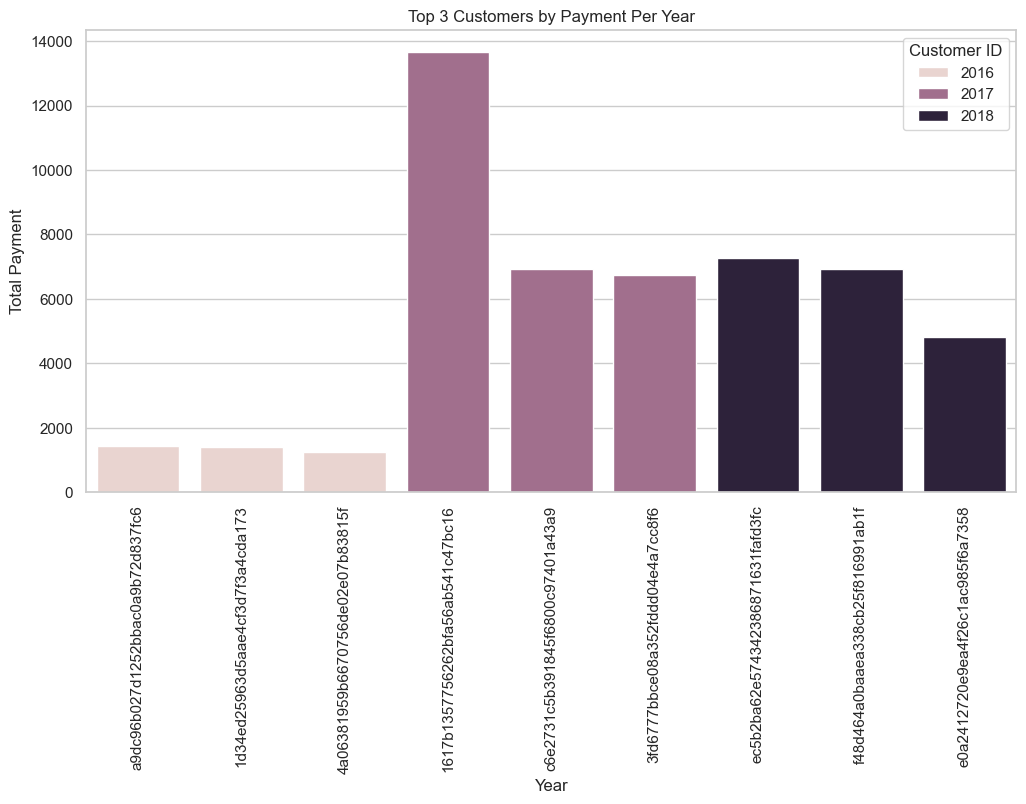

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have imported pandas as pd and executed the SQL query to create the DataFrame df

# Set the style for the plot
sns.set(style="whitegrid")

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="years", y="payment", hue="customer_id", data=df, ci=None)
plt.title("Top 3 Customers by Payment Per Year")
plt.xlabel("Year")
plt.ylabel("Total Payment")
plt.legend(title="Customer ID")
plt.xticks(rotation=90)
plt.show()